
"""
EE541 Final Project – Remaining Useful Life (RUL) Prediction with CNN + LSTM
----------------------------------------------------------------------------

Goal
----
This script trains a CNN + LSTM model to predict the Remaining Useful Life
(RUL) of turbofan engines on the NASA C-MAPSS dataset (FD001–FD004).

Main ideas
----------
- Use *all* 24 input features:
  - 3 operating settings: op1, op2, op3
  - 21 sensor readings:  s1 … s21
- Build time windows of length W ∈ {35, 50} for each engine:
  - input shape to the model: (batch, W, 24)
  - target RUL is the (clipped) RUL at the last time step in the window
- Compare performance across four subsets: FD001, FD002, FD003, FD004.

Data preprocessing
------------------
1. Load raw C-MAPSS files (train_FD00x.txt, test_FD00x.txt, RUL_FD00x.txt).
2. Split engines into 80% train / 20% validation by unit ID.
3. Normalization:
   - FD001 / FD003: global mean/std over all training rows.
   - FD002 / FD004: k-means on (op1, op2, op3) to create cond_id, then
     compute mean/std per condition and normalize within each cond_id.
4. Sliding-window dataset:
   - For each engine, create all possible windows of length W.
   - RUL is computed as (max_cycle - current_cycle) and clipped at 125.

Model architecture (CNNLSTM)
----------------------------
Input: (batch, W, 24)
1. Conv1d over time:
   - in_channels  = 24
   - out_channels = 32
   - kernel_size  = 3
   - padding      = 1  (keep time length)
2. BatchNorm1d on 32 channels + ReLU
3. LSTM over CNN features:
   - input_size  = 32
   - hidden_size = 64
   - num_layers  = 1
   - batch_first = True
4. Dropout on the last hidden state (p = 0.2)
5. Fully connected head:
   - 64 → 32 → 1 (ReLU between the two layers)
Output: scalar RUL prediction per window.

Training setup
--------------
- Loss function: MSE (mean squared error)
- Optimizer: Adam (lr = 3e-4)
- Batch size: 64
- Epochs: 20
- RUL clipping: 125
- Metrics reported on validation set:
  - MSE, RMSE, MAE, NASA score

How to read the code
--------------------
- Cell 0–3:  data loading, train/val split, normalization for FD001–FD004.
- Cell 4:    CmapssTrainDataset – builds sliding-window (sequence, RUL) pairs.
- Cell 5:    CNNLSTM – final CNN + LSTM model used in experiments.
- Cell 6:    nasa_score_np, get_loss_fn, evaluate, and run_experiment()
             (generic training loop for any model class).
- Cell 7–10: helper functions train_fdXXX_two_windows() to run FD001–FD004
             with W = 35 and W = 50 for CNNLSTM.
- Cell 11:   collect best validation metrics across datasets/windows.
- Cell 13–14: plotting functions for summary bar charts and per-epoch curves.

Usage notes
-----------
- This script assumes the CMAPSS data is available under DATA_ROOT
  (default: "/content/CMAPSSData") with the original file names.
- To run CNN + LSTM on all four subsets (FD001–FD004) with W = 35 and 50,
  simply execute the file (or all cells in the notebook) from top to bottom.
"""


In [72]:
# Cell 0: imports, device, seed, config, data path check

import os
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#  device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# seed
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)

# data root & zip check
DATA_ROOT = "/content/CMAPSSData"   # folder after unzip
ZIP_NAME  = "CMAPSSData.zip"        # zip file name in /content

if not os.path.isdir(DATA_ROOT):
    if os.path.exists(ZIP_NAME):
        print(f"Zip exists -> {ZIP_NAME}")
        import zipfile
        with zipfile.ZipFile(ZIP_NAME, "r") as zf:
            zf.extractall(DATA_ROOT)
        print("Unzipped", ZIP_NAME, "to", DATA_ROOT)
    else:
        print("DATA_ROOT not found and zip not found.")
        print("Please upload CMAPSSData.zip to /content.")
else:
    print("Folder exists:", DATA_ROOT)

# list files
if os.path.isdir(DATA_ROOT):
    print("\nFiles inside DATA_ROOT:")
    for fname in sorted(os.listdir(DATA_ROOT)):
        print(" -", fname)

# global config
DATASETS   = ["FD001", "FD002", "FD003", "FD004"]
WINDOWS    = [35, 50]
LOSS_TYPES = ["mse", "mae", "nasa"]

EPOCHS     = 20
BATCH_SIZE = 64
LR         = 0.0003
CLIP_RUL   = 125

# 3 ops + 21 sensors = 24 features
FEATURE_COLS = ["op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]
N_FEATURES   = len(FEATURE_COLS)

print("\nFeature columns:", FEATURE_COLS)
print("Number of features:", N_FEATURES)
print("DATA_ROOT =", DATA_ROOT)


Using device: cuda
Folder exists: /content/CMAPSSData

Files inside DATA_ROOT:
 - Damage Propagation Modeling.pdf
 - RUL_FD001.txt
 - RUL_FD002.txt
 - RUL_FD003.txt
 - RUL_FD004.txt
 - readme.txt
 - test_FD001.txt
 - test_FD002.txt
 - test_FD003.txt
 - test_FD004.txt
 - train_FD001.txt
 - train_FD002.txt
 - train_FD003.txt
 - train_FD004.txt

Feature columns: ['op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Number of features: 24
DATA_ROOT = /content/CMAPSSData


In [4]:
# Cell 1: load CMAPSS FD00x datasets into DataFrames

from IPython.display import display

print("DATA_ROOT =", DATA_ROOT)

# raw columns: 2 (unit, cycle) + 3 ops + 21 sensors = 26
ALL_COLS = ["unit", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]

print("All columns:", ALL_COLS)
print("Feature columns:", FEATURE_COLS)

def load_fd(fd_name: str):
    #Load one CMAPSS subset (e.g., 'FD001') and return:
    assert fd_name in ["FD001", "FD002", "FD003", "FD004"]

    train_path = os.path.join(DATA_ROOT, f"train_{fd_name}.txt")
    test_path  = os.path.join(DATA_ROOT, f"test_{fd_name}.txt")
    rul_path   = os.path.join(DATA_ROOT, f"RUL_{fd_name}.txt")

    print(f"\nLoading {fd_name} ...")
    print("  train:", train_path)
    print("  test :", test_path)
    print("  RUL  :", rul_path)

    # read train
    train_df = pd.read_csv(train_path, sep=r"\s+", header=None)
    train_df.columns = ALL_COLS

    # read test
    test_df = pd.read_csv(test_path, sep=r"\s+", header=None)
    test_df.columns = ALL_COLS

    # read RUL
    rul_df = pd.read_csv(rul_path, sep=r"\s+", header=None)
    rul_df.columns = ["RUL"]

    print(f"  train shape: {train_df.shape}, test shape: {test_df.shape}, RUL shape: {rul_df.shape}")
    print(f"  train units: {train_df['unit'].nunique()}, test units: {test_df['unit'].nunique()}")

    return train_df, test_df, rul_df


# quick check on FD001
train_fd001, test_fd001, rul_fd001 = load_fd("FD001")

print("\nTrain FD001 head():")
display(train_fd001.head())

print("\nRUL FD001 head():")
display(rul_fd001.head())


DATA_ROOT = /content/CMAPSSData
All columns: ['unit', 'cycle', 'op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Feature columns: ['op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

Loading FD001 ...
  train: /content/CMAPSSData/train_FD001.txt
  test : /content/CMAPSSData/test_FD001.txt
  RUL  : /content/CMAPSSData/RUL_FD001.txt
  train shape: (20631, 26), test shape: (13096, 26), RUL shape: (100, 1)
  train units: 100, test units: 100

Train FD001 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



RUL FD001 head():


,RUL
0,112
1,98
2,69
3,82
4,91


In [5]:
# Cell 2: split train/val by unit + global normalization (FD001 / FD003)

def split_train_val_by_unit(df, val_ratio=0.2, random_state=0):
    """Split units into train/val (80/20 by default)."""
    units = df["unit"].unique()
    rng = np.random.default_rng(random_state)
    rng.shuffle(units)

    n_total = len(units)
    n_val = int(n_total * val_ratio)
    val_units = units[:n_val]
    train_units = units[n_val:]

    train_df = df[df["unit"].isin(train_units)].reset_index(drop=True)
    val_df   = df[df["unit"].isin(val_units)].reset_index(drop=True)

    print(f"Total units: {n_total}, train: {len(train_units)}, val: {len(val_units)}")
    print(f"train80 shape: {train_df.shape} val20 shape: {val_df.shape}")
    return train_df, val_df


def compute_global_stats(df, feature_cols):
    """Mean/std over all train rows (single condition)."""
    mean = df[feature_cols].mean()
    std  = df[feature_cols].std().replace(0.0, 1.0)
    return {"mean": mean, "std": std}


def normalize_global(df, feature_cols, stats):
    """(x - mean) / std using global stats."""
    df = df.copy()
    df[feature_cols] = (df[feature_cols] - stats["mean"]) / stats["std"]
    return df


# FD001: split + normalize
train80_fd001, val20_fd001 = split_train_val_by_unit(train_fd001, val_ratio=0.2)

stats_fd001 = compute_global_stats(train80_fd001, FEATURE_COLS)
train80_fd001_norm = normalize_global(train80_fd001, FEATURE_COLS, stats_fd001)
val20_fd001_norm   = normalize_global(val20_fd001,  FEATURE_COLS, stats_fd001)

print("\nFD001 normalized train80 head():")
display(train80_fd001_norm.head())

# FD003: load + split + normalize
train_fd003, test_fd003, rul_fd003 = load_fd("FD003")

train80_fd003, val20_fd003 = split_train_val_by_unit(train_fd003, val_ratio=0.2)
stats_fd003 = compute_global_stats(train80_fd003, FEATURE_COLS)
train80_fd003_norm = normalize_global(train80_fd003, FEATURE_COLS, stats_fd003)
val20_fd003_norm   = normalize_global(val20_fd003,  FEATURE_COLS, stats_fd003)

print("\nFD003 normalized train80 head():")
display(train80_fd003_norm.head())


Total units: 100, train: 80, val: 20
train80 shape: (16362, 26) val20 shape: (4269, 26)

FD001 normalized train80 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.321624,-1.372572,0.0,0.0,-1.732474,-0.127967,-0.934201,-0.001737,...,0.333200,-1.076892,-0.275198,-0.605166,-0.00111,-0.781246,0.0,0.0,1.352557,1.201492
1,1,2,0.867974,-1.032592,0.0,0.0,-1.066760,0.219340,-0.649321,-0.001737,...,1.179367,-0.367422,-0.669683,-0.275457,-0.00111,-0.781246,0.0,0.0,1.019044,1.244269
2,1,3,-1.968760,1.007284,0.0,0.0,-0.663296,-0.408106,-0.530434,-0.001737,...,1.370438,-0.934998,-0.573413,-0.650735,-0.00111,-2.075045,0.0,0.0,0.741117,0.505899
3,1,4,0.318929,-0.012654,0.0,0.0,-0.663296,-1.259991,-0.791761,-0.001737,...,1.970944,-0.225528,-0.540217,-1.980291,-0.00111,-0.781246,0.0,0.0,0.352018,0.782090
4,1,5,-0.870669,-0.692613,0.0,0.0,-0.622950,-1.250162,-0.303876,-0.001737,...,1.056537,-0.793104,-0.541876,-0.339791,-0.00111,-0.134346,0.0,0.0,0.463189,1.065721



Loading FD003 ...
  train: /content/CMAPSSData/train_FD003.txt
  test : /content/CMAPSSData/test_FD003.txt
  RUL  : /content/CMAPSSData/RUL_FD003.txt
  train shape: (24720, 26), test shape: (16596, 26), RUL shape: (100, 1)
  train units: 100, test units: 100
Total units: 100, train: 80, val: 20
train80 shape: (19786, 26) val20 shape: (4934, 26)

FD003 normalized train80 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.214928,1.344393,0.0,0.0,-0.202072,-0.721621,-0.793777,-0.001063,...,-0.199921,-0.388632,0.050048,0.428924,-0.000921,-0.897972,0.0,0.0,0.527297,-0.227125
1,1,2,0.375699,-1.035630,0.0,0.0,0.064676,-0.507114,-0.788669,-0.001063,...,-0.165219,-0.259999,0.497515,0.691507,-0.000921,-0.330237,0.0,0.0,0.043172,0.414420
2,1,3,-0.623823,-0.695627,0.0,0.0,-0.545033,-0.850912,0.102184,-0.001063,...,-0.288251,-0.452949,0.338257,-0.148091,-0.000921,-0.897972,0.0,0.0,-0.521641,-0.138358
3,1,4,-0.896420,0.324383,0.0,0.0,0.864920,-0.371946,-1.260658,-0.001063,...,-0.143137,0.061583,0.123734,-0.186558,-0.000921,-0.330237,0.0,0.0,-0.077859,-0.621198
4,1,5,0.739161,-0.015620,0.0,0.0,-1.497704,0.071759,-0.711026,-0.001063,...,-0.114745,-0.259999,0.197421,-0.201611,-0.000921,-0.330237,0.0,0.0,0.648328,0.476288


In [6]:
# Cell 3: FD002 / FD004 – k-means condition-wise normalization

from sklearn.cluster import KMeans

def add_kmeans_cond_id(train_df, val_df, n_cond=6, random_state=0):
    """Use k-means on (op1, op2, op3) to create cond_id."""
    train_df = train_df.copy()
    val_df   = val_df.copy()

    kmeans = KMeans(n_clusters=n_cond, random_state=random_state, n_init=10)

    train_ops = train_df[["op1", "op2", "op3"]].values
    val_ops   = val_df[["op1", "op2", "op3"]].values

    train_df["cond_id"] = kmeans.fit_predict(train_ops)
    val_df["cond_id"]   = kmeans.predict(val_ops)

    print("Found conditions in train:", sorted(train_df["cond_id"].unique()))
    return train_df, val_df, kmeans


def compute_cond_stats_by_id(df, feature_cols):
    """Mean/std per cond_id."""
    stats = {}
    for cid, g in df.groupby("cond_id"):
        mean = g[feature_cols].mean()
        std  = g[feature_cols].std().replace(0.0, 1.0)
        stats[cid] = {"mean": mean, "std": std}
    print("Number of conditions in train:", len(stats))
    return stats


def normalize_by_condid(df, feature_cols, cond_stats):
    """Normalize (x - mean_cid) / std_cid for each cond_id."""
    df = df.copy()
    df[feature_cols] = df[feature_cols].astype("float32")

    for cid, idx in df.groupby("cond_id").groups.items():
        mean = cond_stats[cid]["mean"]
        std  = cond_stats[cid]["std"]
        # ensure numpy array to avoid dtype warning
        vals = df.loc[idx, feature_cols].values
        df.loc[idx, feature_cols] = ((vals - mean.values) / std.values).astype("float32")
    return df


def prepare_fd_multi_cond(fd_name, n_cond=6, val_ratio=0.2):

    #For FD002 / FD004:
      #1) load data
      #2) split train/val by unit
      #3) k-means on (op1, op2, op3) -> cond_id
      #4) condition-wise normalization

    # load
    train_df, test_df, rul_df = load_fd(fd_name)

    # split units
    train80, val20 = split_train_val_by_unit(train_df, val_ratio=val_ratio)

    # add cond_id with k-means
    train80_c, val20_c, km = add_kmeans_cond_id(train80, val20, n_cond=n_cond)

    # compute stats per cond_id + normalize
    cond_stats = compute_cond_stats_by_id(train80_c, FEATURE_COLS)
    train80_norm = normalize_by_condid(train80_c, FEATURE_COLS, cond_stats)
    val20_norm   = normalize_by_condid(val20_c, FEATURE_COLS, cond_stats)

    print(f"\n{fd_name} normalized train80 head():")
    display(train80_norm.head())

    return train80_norm, val20_norm, test_df, rul_df, cond_stats, km


# prepare FD002
train80_fd002_norm, val20_fd002_norm, test_fd002, rul_fd002, cond_stats_fd002, km_fd002 = \
    prepare_fd_multi_cond("FD002", n_cond=6, val_ratio=0.2)

# prepare FD004
train80_fd004_norm, val20_fd004_norm, test_fd004, rul_fd004, cond_stats_fd004, km_fd004 = \
    prepare_fd_multi_cond("FD004", n_cond=6, val_ratio=0.2)



Loading FD002 ...
  train: /content/CMAPSSData/train_FD002.txt
  test : /content/CMAPSSData/test_FD002.txt
  RUL  : /content/CMAPSSData/RUL_FD002.txt
  train shape: (53759, 26), test shape: (33991, 26), RUL shape: (259, 1)
  train units: 260, test units: 259
Total units: 260, train: 208, val: 52
train80 shape: (42665, 26) val20 shape: (11094, 26)
Found conditions in train: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
Number of conditions in train: 6

FD002 normalized train80 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cond_id
0,2,1,1.135236,-0.766185,0.0,-378619.937500,-1.289671,-0.261449,-0.517750,-192296.953125,...,-0.136461,0.074751,-0.375924,-659585.062500,-0.138074,0.0,0.0,0.360911,-0.542880,4
1,2,2,0.955907,-0.772108,0.0,53884.980469,0.750096,-0.509785,-0.923557,140347.453125,...,-0.057274,0.052538,0.035164,-352019.062500,-0.162913,0.0,0.0,0.257290,0.109792,5
2,2,3,0.563284,-0.766185,0.0,-378619.937500,0.159663,-0.407926,-0.132926,-192296.953125,...,-0.136461,0.000928,-0.408421,-659585.062500,-0.138074,0.0,0.0,-0.489933,-0.692298,4
3,2,4,-1.094310,-0.757215,0.0,0.000000,0.598440,-1.076889,-0.755082,135529.062500,...,0.386725,0.214304,-0.703458,-135910.296875,-0.044669,0.0,0.0,0.868168,0.917941,2
4,2,5,1.020846,2.321715,0.0,-378619.937500,-0.947394,-0.634295,-0.210334,-192296.953125,...,-0.846759,0.328915,-0.492402,-659585.062500,-1.452083,0.0,0.0,1.211732,1.130293,4



Loading FD004 ...
  train: /content/CMAPSSData/train_FD004.txt
  test : /content/CMAPSSData/test_FD004.txt
  RUL  : /content/CMAPSSData/RUL_FD004.txt
  train shape: (61249, 26), test shape: (41214, 26), RUL shape: (248, 1)
  train units: 249, test units: 248
Total units: 249, train: 200, val: 49
train80 shape: (48928, 26) val20 shape: (12321, 26)
Found conditions in train: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
Number of conditions in train: 6

FD004 normalized train80 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cond_id
0,2,1,-1.103919,-0.767897,0.0,0.00000,-1.046024,-1.620456,-1.247664,83268.289062,...,-0.409877,-0.482725,-0.028428,-1.050928e+05,0.280537,0.0,0.000000,1.237262,-1.170933,5
1,2,2,-1.056691,-0.780029,0.0,-207472.28125,-0.903301,-0.306563,-0.840187,818033.500000,...,-0.395914,-0.697779,-0.203970,2.329392e-02,-0.717263,0.0,0.000000,-0.140575,1.148969,1
2,2,3,1.695193,-0.299165,0.0,0.00000,-0.787965,-0.159180,0.219146,83268.289062,...,-0.595057,-0.497738,-0.493875,-1.050928e+05,-0.320086,0.0,0.000000,0.648696,0.782120,5
3,2,4,1.626633,-0.767897,0.0,0.00000,-1.519088,-1.016245,-0.863002,83268.289062,...,-0.780237,-0.653471,-0.167372,-1.050928e+05,-0.320086,0.0,0.000000,-1.032904,-1.277417,5
4,2,5,-1.085904,-0.776481,0.0,285224.84375,0.677516,-0.186906,-0.368818,265430.875000,...,-0.774473,-0.893269,0.277920,-7.157786e+06,0.132223,0.0,123410.085938,-0.390963,-0.117178,2


In [63]:
# Cell 4: sliding window maker + Dataset class (shared by all models)

class CmapssTrainDataset(Dataset):
    """Create (sequence, RUL) pairs from one FD00x train DataFrame."""

    def __init__(self, df, window, feature_cols, clip_rul=125):

        #df         : normalized train80 or val20 DataFrame
        #window       : W (e.g., 35 or 50)
        #feature_cols    : list of feature names (24 features)
        #clip_rul      : cap RUL at this value

        X, y = self._build_sequences(df, window, feature_cols, clip_rul)
        self.X = X    # shape: (N, W, F)
        self.y = y    # shape: (N,)

    @staticmethod
    def _build_sequences(df, window, feature_cols, clip_rul):
        """Make sliding windows per unit."""
        xs = []
        ys = []

        for unit_id, g in df.groupby("unit"):
            g = g.sort_values("cycle")

            cycles = g["cycle"].values
            max_cycle = cycles[-1]
            rul_full = max_cycle - cycles  # RUL at each time step

            if clip_rul is not None:
                rul_full = np.minimum(rul_full, clip_rul)

            feats = g[feature_cols].values.astype(np.float32)
            T = len(g)

            if T < window:
                continue  # skip very short engines

            # sliding window over time
            for start in range(0, T - window + 1):
                end = start + window
                xs.append(feats[start:end])     # (W, F)
                ys.append(rul_full[end - 1])    # RUL at last step of window

        X = np.stack(xs).astype(np.float32)
        y = np.array(ys, dtype=np.float32)
        print(f"Built {X.shape[0]} samples, window={window}, features={X.shape[2]}")
        return X, y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])       # (W, F)
        y = torch.tensor(self.y[idx])           # scalar
        return x, y


# quick check: FD001, window=35
train_ds_fd001_w35 = CmapssTrainDataset(train80_fd001_norm, window=35,
                                        feature_cols=FEATURE_COLS, clip_rul=CLIP_RUL)
print("FD001 train dataset (w=35) size:", len(train_ds_fd001_w35))

x0, y0 = train_ds_fd001_w35[0]
print("One sample x shape:", x0.shape)  # expect (35, 24)
print("One sample y:", y0)

Built 13642 samples, window=35, features=24
FD001 train dataset (w=35) size: 13642
One sample x shape: torch.Size([35, 24])
One sample y: tensor(125.)


In [65]:
# Cell 5: CNN + LSTM model (with dropout + BatchNorm, no temporal pooling)

class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int = N_FEATURES,   # 24 features
        conv_channels: int = 32,
        hidden_dim: int = 64,
        fc_dim: int = 32,
        dropout_p: float = 0.2,
    ):
        super().__init__()

        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=conv_channels,
            kernel_size=3,
            padding=1,
        )
        self.bn1 = nn.BatchNorm1d(conv_channels)

        self.relu = nn.ReLU()
        self.pool = nn.Identity()  # no downsampling in time

        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=dropout_p)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, 1)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.transpose(1, 2)

        out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]

        h_last = self.dropout(h_last)

        x = self.fc1(h_last)
        x = self.relu(x)
        x = self.fc2(x)

        return x.squeeze(-1)


train_loader_fd001_w35 = DataLoader(
    train_ds_fd001_w35,
    batch_size=64,
    shuffle=True,
)

batch_x, batch_y = next(iter(train_loader_fd001_w35))
batch_x = batch_x.to(DEVICE)

model_cnn_lstm = CNNLSTM().to(DEVICE)
with torch.no_grad():
    y_pred = model_cnn_lstm(batch_x)

print("batch_x shape:", batch_x.shape)
print("y_pred shape:", y_pred.shape)


batch_x shape: torch.Size([64, 35, 24])
y_pred shape: torch.Size([64])


In [36]:
# Cell 6: loss, metrics, and a generic training loop

#  NASA score

def nasa_score_np(y_true, y_pred):
    """NASA score (numpy version)."""
    e = y_pred - y_true
    score = 0.0
    for err in e:
        if err < 0:
            score += np.exp(-err / 13.0) - 1.0
        else:
            score += np.exp(err / 10.0) - 1.0
    return score


def get_loss_fn(name="mse"):
    """Return a PyTorch loss function."""
    name = name.lower()
    if name == "mse":
        return nn.MSELoss()
    elif name == "mae":
        return nn.L1Loss()
    else:
        raise ValueError(f"Unknown loss type: {name}")


def evaluate(model, data_loader):
    """Compute MSE, RMSE, MAE, NASA on a DataLoader."""
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            pred = model(x)
            all_true.append(y.cpu().numpy())
            all_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    mse  = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(y_pred - y_true))
    nasa = nasa_score_np(y_true, y_pred)
    return mse, rmse, mae, nasa


# map FD name  normalized train/val DataFrame
TRAIN_NORM = {
    "FD001": train80_fd001_norm,
    "FD002": train80_fd002_norm,
    "FD003": train80_fd003_norm,
    "FD004": train80_fd004_norm,
}

VAL_NORM = {
    "FD001": val20_fd001_norm,
    "FD002": val20_fd002_norm,
    "FD003": val20_fd003_norm,
    "FD004": val20_fd004_norm,
}


def run_experiment(
    fd_name,
    window,
    model_class,
    loss_type="mse",
    save_model=False,
):

    #Train one model on one FD00x with given window size.


    print(f"\n===== {fd_name} | w={window} | model={model_class.__name__} "
          f"| loss={loss_type} | epochs={EPOCHS} =====")

    # build datasets
    train_df = TRAIN_NORM[fd_name]
    val_df   = VAL_NORM[fd_name]

    train_ds = CmapssTrainDataset(train_df, window, FEATURE_COLS, CLIP_RUL)
    val_ds   = CmapssTrainDataset(val_df,   window, FEATURE_COLS, CLIP_RUL)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # model / optimizer / loss
    model = model_class().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = get_loss_fn(loss_type)

    history = []           # save metrics for each epoch
    best_rmse = float("inf")
    best_info = None
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_losses = []

        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        val_mse, val_rmse, val_mae, val_nasa = evaluate(model, val_loader)

        history.append({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_mse": val_mse,
            "val_rmse": val_rmse,
            "val_mae": val_mae,
            "val_nasa": val_nasa,
        })

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_info = {
                "epoch": epoch,
                "mse": val_mse,
                "rmse": val_rmse,
                "mae": val_mae,
                "nasa": val_nasa,
            }
            best_state = model.state_dict()

        print(
            f"Epoch {epoch:02d} "
            f"| train_loss={avg_train_loss:.4f} "
            f"| val_rmse={val_rmse:.3f} "
            f"| val_mae={val_mae:.3f} "
            f"| val_nasa={val_nasa:.1f}"
        )

    print("\nBest epoch (by val RMSE):", best_info["epoch"])
    print(f"  MSE  = {best_info['mse']:.3f}")
    print(f"  RMSE = {best_info['rmse']:.3f}")
    print(f"  MAE  = {best_info['mae']:.3f}")
    print(f"  NASA = {best_info['nasa']:.1f}")

    best_path = None
    if save_model and best_state is not None:
        best_path = f"{model_class.__name__.lower()}_{fd_name}_w{window}_{loss_type}.pt"
        torch.save(best_state, best_path)
        print("Saved best model to:", best_path)

    return history, best_info, best_path


In [84]:
# Cell 7: Run FD001 experiments (w = 35, 50) for a given model

def train_fd001_two_windows(model_class, loss_type="mse", save_model=False):

    #Train the same model on FD001 with window=35 and window=50.


    results = {}
    for w in [35, 50]:
        history, best_info, best_path = run_experiment(
            fd_name="FD001",
            window=w,
            model_class=model_class,
            loss_type=loss_type,
            save_model=save_model,
        )
        results[w] = {
            "history": history,
            "best_info": best_info,
            "best_path": best_path,
        }
    return results



if __name__ == "__main__":
    fd001_results_cnn_lstm = train_fd001_two_windows(
        model_class=CNNLSTM,
        loss_type="mse",
        save_model=True,
    )




===== FD001 | w=35 | model=CNNLSTM | loss=mse | epochs=20 =====
Built 13642 samples, window=35, features=24
Built 3589 samples, window=35, features=24
Epoch 01 | train_loss=6955.8464 | val_rmse=75.640 | val_mae=64.970 | val_nasa=4989901.5
Epoch 02 | train_loss=3907.8108 | val_rmse=52.934 | val_mae=45.931 | val_nasa=499282.1
Epoch 03 | train_loss=1788.0308 | val_rmse=31.344 | val_mae=25.310 | val_nasa=56723.8
Epoch 04 | train_loss=646.4245 | val_rmse=20.633 | val_mae=16.809 | val_nasa=18990.2
Epoch 05 | train_loss=360.9948 | val_rmse=16.882 | val_mae=13.963 | val_nasa=15915.9
Epoch 06 | train_loss=272.1139 | val_rmse=13.923 | val_mae=10.997 | val_nasa=10310.0
Epoch 07 | train_loss=218.2691 | val_rmse=15.468 | val_mae=11.774 | val_nasa=11561.4
Epoch 08 | train_loss=197.1375 | val_rmse=13.227 | val_mae=9.724 | val_nasa=9449.6
Epoch 09 | train_loss=182.3044 | val_rmse=13.135 | val_mae=9.623 | val_nasa=12676.6
Epoch 10 | train_loss=172.6383 | val_rmse=13.460 | val_mae=9.931 | val_nasa=1094

In [38]:
# Cell 8: Run FD003 experiments (w = 35, 50) for a given model

def train_fd003_two_windows(model_class, loss_type="mse", save_model=False):

    #Train the same model on FD003 with window=35 and window=50.


    results = {}
    for w in [35, 50]:
        history, best_info, best_path = run_experiment(
            fd_name="FD003",
            window=w,
            model_class=model_class,
            loss_type=loss_type,
            save_model=save_model,
        )
        results[w] = {
            "history": history,
            "best_info": best_info,
            "best_path": best_path,
        }
    return results


In [88]:
# train  FD003 with w=35 & 50
fd003_results_cnn_lstm = train_fd003_two_windows(
    model_class=CNNLSTM,
    loss_type="mse",
    save_model=True,
)



===== FD003 | w=35 | model=CNNLSTM | loss=mse | epochs=20 =====
Built 17066 samples, window=35, features=24
Built 4254 samples, window=35, features=24
Epoch 01 | train_loss=7933.7165 | val_rmse=74.937 | val_mae=65.570 | val_nasa=4183637.0
Epoch 02 | train_loss=3524.9308 | val_rmse=41.655 | val_mae=36.269 | val_nasa=164592.9
Epoch 03 | train_loss=841.4471 | val_rmse=23.366 | val_mae=20.081 | val_nasa=55822.7
Epoch 04 | train_loss=310.0458 | val_rmse=19.623 | val_mae=15.621 | val_nasa=39104.0
Epoch 05 | train_loss=236.6844 | val_rmse=18.530 | val_mae=13.845 | val_nasa=36327.3
Epoch 06 | train_loss=209.2681 | val_rmse=18.770 | val_mae=13.435 | val_nasa=40168.9
Epoch 07 | train_loss=201.6702 | val_rmse=17.278 | val_mae=12.309 | val_nasa=29088.0
Epoch 08 | train_loss=182.5593 | val_rmse=17.252 | val_mae=12.072 | val_nasa=28520.1
Epoch 09 | train_loss=170.3470 | val_rmse=17.517 | val_mae=12.300 | val_nasa=32203.0
Epoch 10 | train_loss=170.6621 | val_rmse=16.486 | val_mae=11.495 | val_nasa=2

In [61]:
# Cell 9: Run FD002 experiments (w = 35, 50) for a given model

def train_fd002_two_windows(model_class, loss_type="mse", save_model=False):

    #Train the same model on FD002 with window=35 and window=50.


    results = {}
    for w in [35, 50]:
        history, best_info, best_path = run_experiment(
            fd_name="FD002",
            window=w,
            model_class=model_class,
            loss_type=loss_type,
            save_model=save_model,
        )
        results[w] = {
            "history": history,
            "best_info": best_info,
            "best_path": best_path,
        }
    return results


In [89]:
#train CNNLSTM on FD002 with w=35 & 50
fd002_results_cnn_lstm = train_fd002_two_windows(
    model_class=CNNLSTM,
    loss_type="mse",
    save_model=True,
)



===== FD002 | w=35 | model=CNNLSTM | loss=mse | epochs=20 =====
Built 35593 samples, window=35, features=24
Built 9326 samples, window=35, features=24
Epoch 01 | train_loss=4922.5019 | val_rmse=48.251 | val_mae=42.545 | val_nasa=804248.4
Epoch 02 | train_loss=1836.4018 | val_rmse=41.907 | val_mae=37.431 | val_nasa=1526415.0
Epoch 03 | train_loss=1760.8525 | val_rmse=41.930 | val_mae=37.473 | val_nasa=1481075.5
Epoch 04 | train_loss=1764.2399 | val_rmse=41.856 | val_mae=37.314 | val_nasa=1672640.4
Epoch 05 | train_loss=1761.6795 | val_rmse=41.860 | val_mae=37.327 | val_nasa=1655253.4
Epoch 06 | train_loss=1764.2456 | val_rmse=41.904 | val_mae=37.425 | val_nasa=1533449.5
Epoch 07 | train_loss=1762.9817 | val_rmse=41.914 | val_mae=37.446 | val_nasa=1511365.5
Epoch 08 | train_loss=1763.0373 | val_rmse=41.890 | val_mae=37.397 | val_nasa=1566102.0
Epoch 09 | train_loss=1764.8900 | val_rmse=41.897 | val_mae=37.410 | val_nasa=1550732.0
Epoch 10 | train_loss=1761.8817 | val_rmse=41.902 | val_m

In [32]:
# Cell 10: Run FD004 experiments (w = 35, 50) for a given model

def train_fd004_two_windows(model_class, loss_type="mse", save_model=False):

    #Train the same model on FD004 with window=35 and window=50.


    results = {}
    for w in [35, 50]:
        history, best_info, best_path = run_experiment(
            fd_name="FD004",
            window=w,
            model_class=model_class,
            loss_type=loss_type,
            save_model=save_model,
        )
        results[w] = {
            "history": history,
            "best_info": best_info,
            "best_path": best_path,
        }
    return results


In [90]:
# Train CNNLSTM on FD004 with w=35 & 50
fd004_results_cnn_lstm = train_fd004_two_windows(
    model_class=CNNLSTM,
    loss_type="mse",
    save_model=True,
)



===== FD004 | w=35 | model=CNNLSTM | loss=mse | epochs=20 =====
Built 42128 samples, window=35, features=24
Built 10655 samples, window=35, features=24
Epoch 01 | train_loss=5299.2036 | val_rmse=44.633 | val_mae=40.880 | val_nasa=998705.8
Epoch 02 | train_loss=1788.3597 | val_rmse=41.547 | val_mae=37.132 | val_nasa=3027048.2
Epoch 03 | train_loss=1762.5688 | val_rmse=41.517 | val_mae=37.012 | val_nasa=3207430.2
Epoch 04 | train_loss=1759.0479 | val_rmse=41.500 | val_mae=36.913 | val_nasa=3370966.2
Epoch 05 | train_loss=1761.5228 | val_rmse=41.541 | val_mae=37.088 | val_nasa=3101695.2
Epoch 06 | train_loss=1761.8163 | val_rmse=41.512 | val_mae=36.956 | val_nasa=3306561.0
Epoch 07 | train_loss=1761.0566 | val_rmse=41.505 | val_mae=36.898 | val_nasa=3409251.2
Epoch 08 | train_loss=1759.6265 | val_rmse=41.572 | val_mae=37.184 | val_nasa=2968797.0
Epoch 09 | train_loss=1761.5873 | val_rmse=41.516 | val_mae=36.962 | val_nasa=3301612.2
Epoch 10 | train_loss=1763.8306 | val_rmse=41.543 | val_

In [93]:
#cell 11
import pandas as pd

# Collect best metrics for CNNLSTM: one row = (dataset, window, rmse, mae, nasa)
rows = []

cnnlstm_results_all = {
    "FD001": fd001_results_cnnlstm,
    "FD002": fd002_results_cnnlstm,
    "FD003": fd003_results_cnnlstm,
    "FD004": fd004_results_cnnlstm,
}

for fd_name, fd_results in cnnlstm_results_all.items():
    for w in [35, 50]:
        best = fd_results[w]["best_info"]
        rows.append({
            "dataset": fd_name,
            "window": w,
            "rmse": best["rmse"],
            "mae": best["mae"],
            "nasa": best["nasa"],
        })

cnnlstm_summary = pd.DataFrame(rows)
cnnlstm_summary


,dataset,window,rmse,mae,nasa
0,FD001,35,13.052820,9.721564,1.067605e+04
1,FD001,50,11.828174,8.886608,7.321104e+03
2,FD002,35,41.844692,37.274757,1.729598e+06
3,FD002,50,41.653305,36.974838,1.146615e+06
4,FD003,35,16.972462,12.579284,2.564084e+04
5,FD003,50,16.035301,10.995330,2.384966e+04
6,FD004,35,41.383457,36.546234,3.648403e+06
7,FD004,50,41.868107,37.271999,2.835006e+06


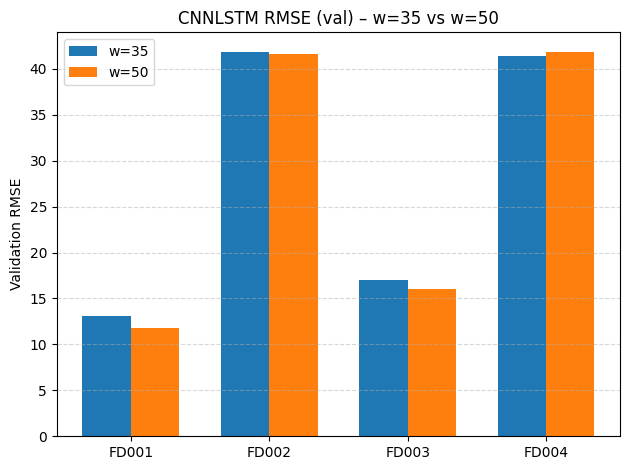

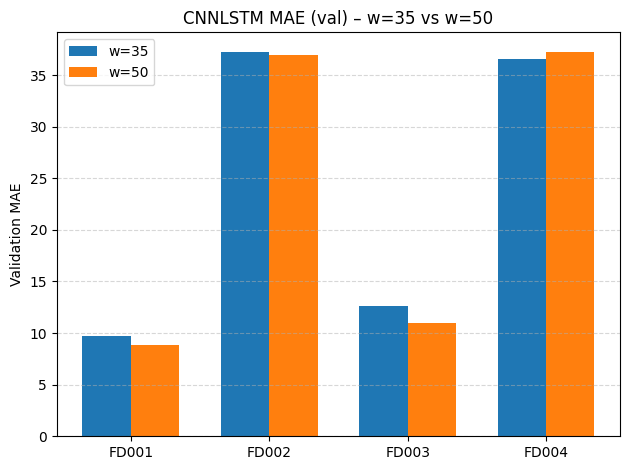

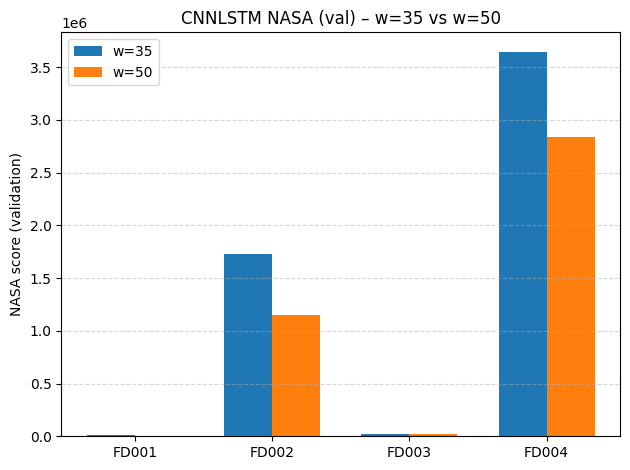

In [94]:
#cell 13
import matplotlib.pyplot as plt

# helper: grouped bar chart for one metric (CNNLSTM)
def plot_metric_cnn(metric_name, ylabel):

    #metric_name: 'rmse', 'mae', or 'nasa'

    # pivot to: index = dataset, columns = window, values = metric
    pivot = cnnlstm_summary.pivot(index="dataset", columns="window", values=metric_name)

    datasets = pivot.index.tolist()       # ['FD001', 'FD002', ...]
    windows  = pivot.columns.tolist()     # [35, 50]
    x = range(len(datasets))

    width = 0.35  # bar width

    plt.figure()

    # bars for w=35 and w=50
    plt.bar([i - width/2 for i in x], pivot[35].values, width=width, label="w=35")
    plt.bar([i + width/2 for i in x], pivot[50].values, width=width, label="w=50")

    plt.xticks(x, datasets)
    plt.ylabel(ylabel)
    plt.title(f"CNNLSTM {metric_name.upper()} (val) – w=35 vs w=50")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# RMSE bar chart
plot_metric_cnn("rmse", "Validation RMSE")

# MAE bar chart
plot_metric_cnn("mae", "Validation MAE")

# NASA bar chart
plot_metric_cnn("nasa", "NASA score (validation)")


In [105]:
# Cell 14: plot metric curves (val MSE / MAE / NASA) for one dataset, w=35 and w=50

import matplotlib.pyplot as plt
import pandas as pd

def plot_metric_history(results_dict, dataset_name, metric_key, ylabel, title_suffix):

    #Plot a validation metric vs epoch for one dataset (w=35 and w=50).


    # history for w=35 and w=50
    df_35 = pd.DataFrame(results_dict[35]["history"])
    df_50 = pd.DataFrame(results_dict[50]["history"])

    plt.figure()
    plt.plot(df_35["epoch"], df_35[metric_key], label="w=35")
    plt.plot(df_50["epoch"], df_50[metric_key], label="w=50")

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"{dataset_name} {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


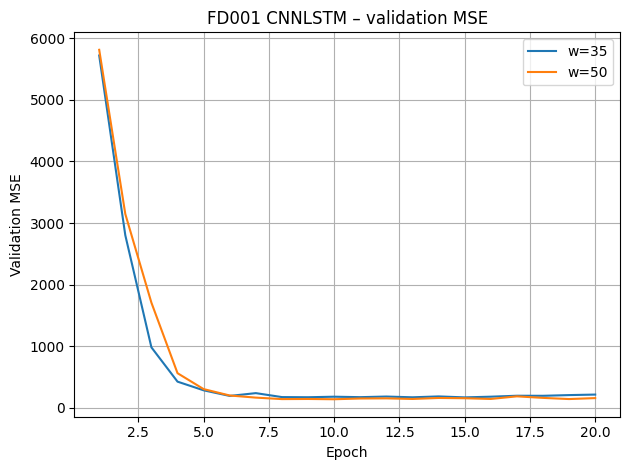

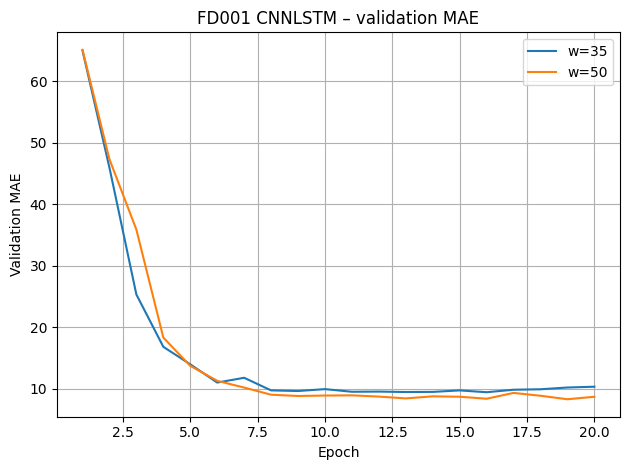

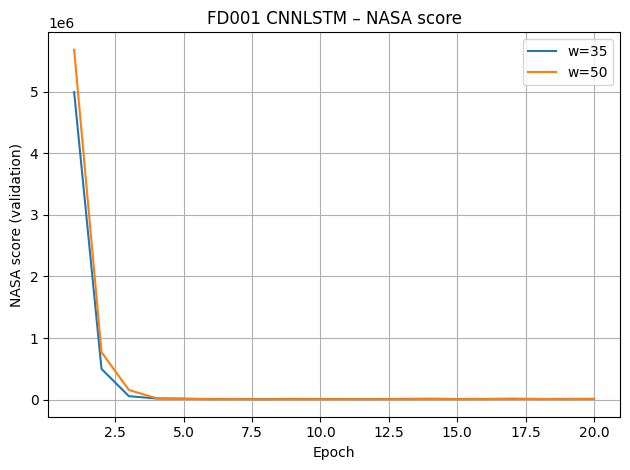

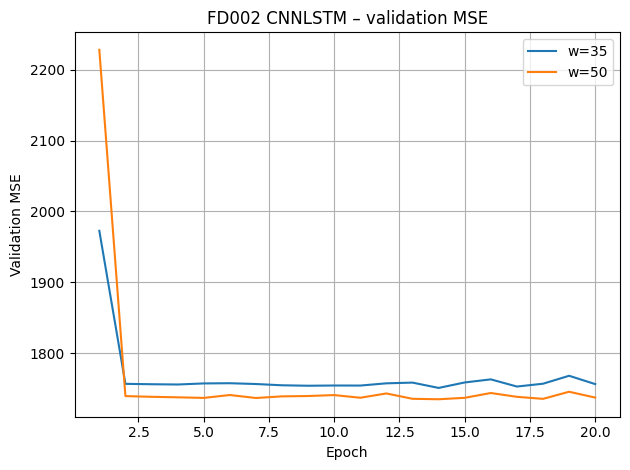

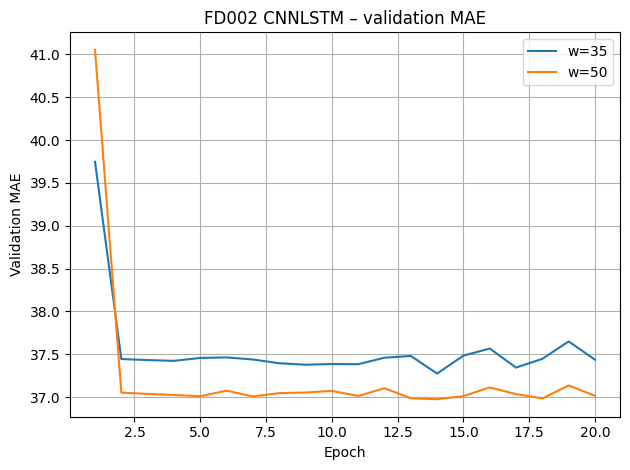

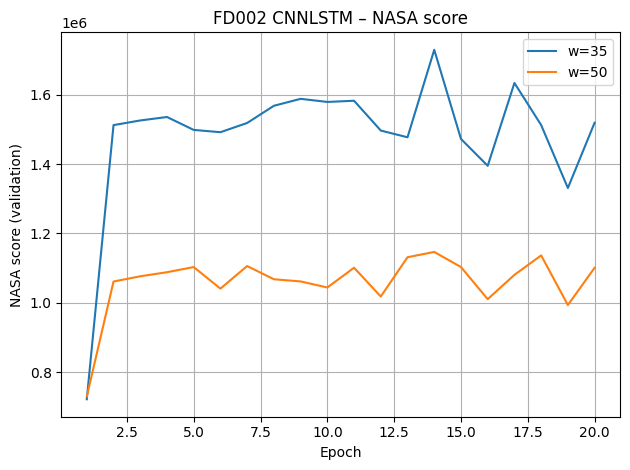

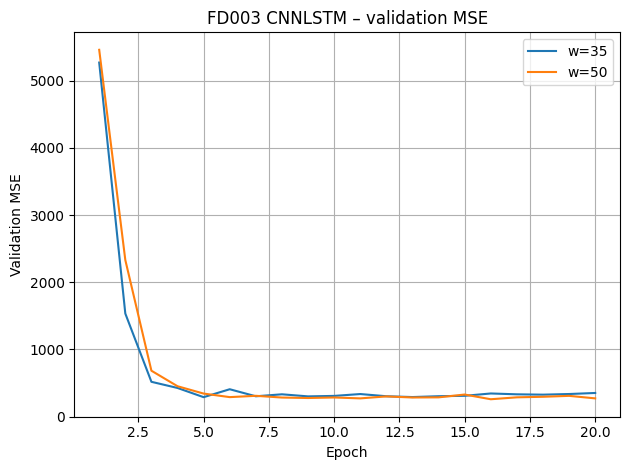

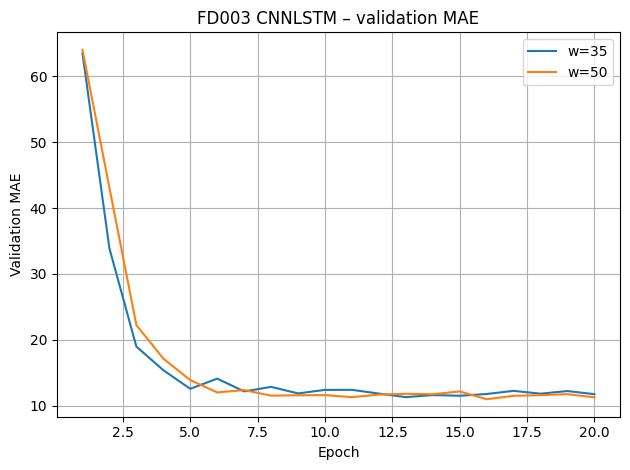

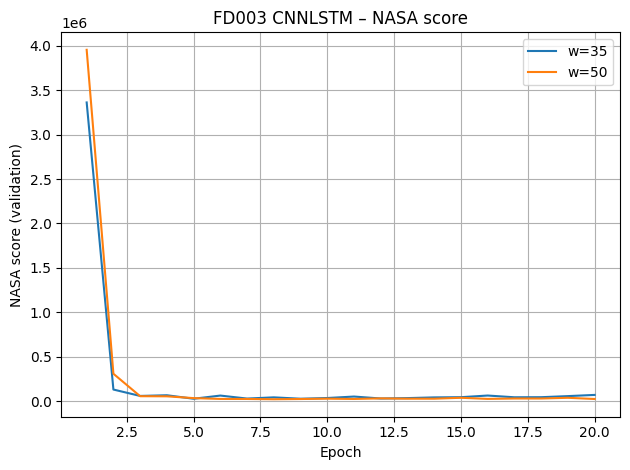

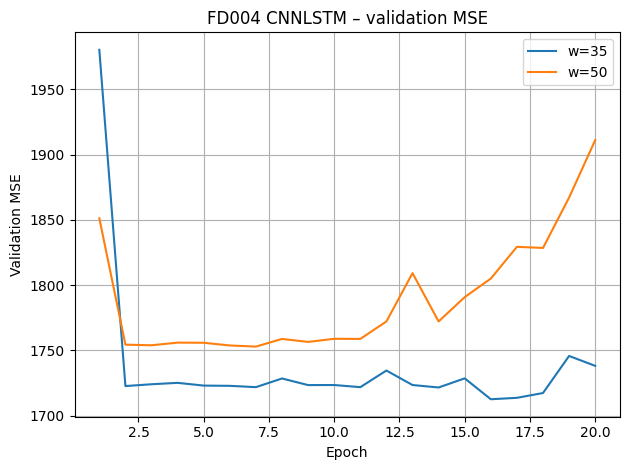

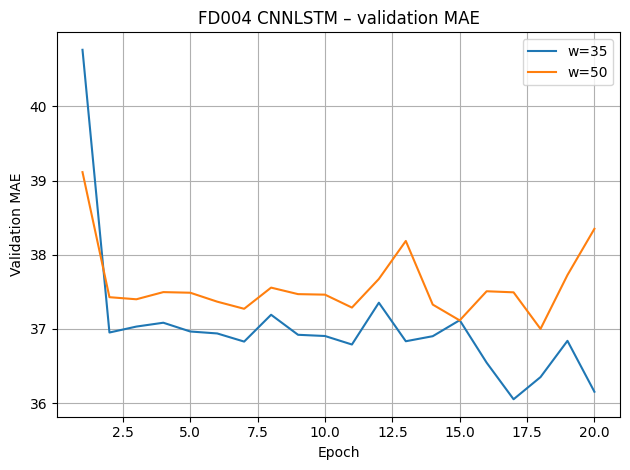

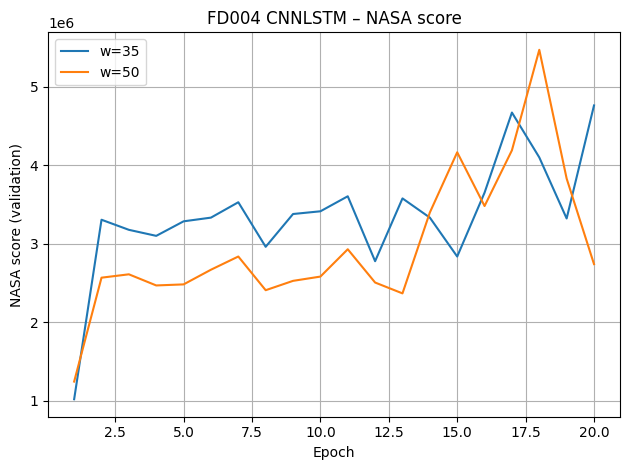

In [106]:
# Assume these exist:
# fd001_results_cnnlstm, fd002_results_cnnlstm, fd003_results_cnnlstm, fd004_results_cnnlstm

cnn_results_all = {
    "FD001": fd001_results_cnnlstm,
    "FD002": fd002_results_cnnlstm,
    "FD003": fd003_results_cnnlstm,
    "FD004": fd004_results_cnnlstm,
}

# 3 metrics × 4 datasets = 12 figures
for fd_name, res in cnn_results_all.items():
    # val MSE
    plot_metric_history(
        res,
        dataset_name=fd_name,
        metric_key="val_mse",
        ylabel="Validation MSE",
        title_suffix="CNNLSTM – validation MSE",
    )

    # val MAE
    plot_metric_history(
        res,
        dataset_name=fd_name,
        metric_key="val_mae",
        ylabel="Validation MAE",
        title_suffix="CNNLSTM – validation MAE",
    )

    # NASA score
    plot_metric_history(
        res,
        dataset_name=fd_name,
        metric_key="val_nasa",
        ylabel="NASA score (validation)",
        title_suffix="CNNLSTM – NASA score",
    )
